In [81]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [82]:
def model_basic(x_train, y_train, x_test, y_test):
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier(),
        
    ]

    rdict = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc_score': []}

    for clf in models:
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        pred_prob_rf = clf.predict_proba(x_test)[:, 1].reshape(-1, 1)
        auc_score = roc_auc_score(y_test, pred_prob_rf)
        results = (
            round(accuracy_score(y_test, pred), 4),
            round(precision_score(y_test, pred), 4),
            round(recall_score(y_test, pred), 4),
            round(f1_score(y_test, pred), 4),
            round(auc_score, 4)
        )

        rdict['model'].append(clf)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['auc_score'].append(results[4])

        confusion = confusion_matrix(y_test, pred)
        print(confusion)

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [83]:
train = pd.read_csv('./datasets/통계검증완료/코스피_standard_train.csv',index_col=0)
test =  pd.read_csv('./datasets/통계검증완료/코스피_standard_test.csv',index_col=0)

In [84]:
# train = pd.read_csv('./datasets/통계검증완료/코스피_robu_train.csv',index_col=0)
# test =  pd.read_csv('./datasets/통계검증완료/코스피_robu_test.csv',index_col=0)
# np.random.RandomState(1)

---
# 산업별 더미변수 - 제조업,건설업,정보통신업,그외
---

In [85]:
# train.loc[~(train['산업군'].str.contains('제조업') | train['산업군'].str.contains('건설업') | train['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(train['산업군'])
# train = pd.concat([train,dummy_df],axis=1)

In [86]:
# test.loc[~(test['산업군'].str.contains('제조업') | test['산업군'].str.contains('건설업') | test['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(test['산업군'])
# test = pd.concat([test,dummy_df],axis=1)

----

In [87]:
train.columns

Index(['회사명', '거래소코드', '회계년도', '산업군', 'target_1', 'target_2', 'target_3',
       '현금흐름/총부채비율', '총자본정상영업이익률', '현금흐름 대 자산', 'EBIT/총자산', '타인자본회전률',
       '당기전기영업손익', '이익잉여금', '총자본회전률', '차입금의존도', '누적수익성비율', 'EBITDA마진율',
       '순운전자본비율', 'TMD', '금융비용부담률', '자기자본순이익률', '부채비율', '외국인지분율', 'ROA변화율',
       '총자본증가율', '매출액총이익률', '매출액증가율', '영업현금흐름-단기차입금', '자본금회전률', '정상영업이익증가율',
       '대주주지분율'],
      dtype='object')

In [88]:
col_int =['현금흐름/총부채비율', '총자본정상영업이익률', '현금흐름 대 자산', 'EBIT/총자산', '타인자본회전률',
       '당기전기영업손익', '이익잉여금', '총자본회전률', '차입금의존도', '누적수익성비율', 'EBITDA마진율',
       '순운전자본비율', 'TMD', '금융비용부담률', '자기자본순이익률', '부채비율', '외국인지분율', 'ROA변화율',
       '총자본증가율', '매출액총이익률', '매출액증가율', '영업현금흐름-단기차입금', '자본금회전률', '정상영업이익증가율',
       '대주주지분율']

---
#target1
---

In [89]:
x_train = train[col_int]
y_train = train[['target_1']]

x_test = test[col_int]
y_test = test[['target_1']]

In [90]:
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select.index = x_train.columns

---
# lasso - 임베디드기법
---

In [91]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select["lasso_0.1"] = selector.get_support()


---
# stepwise - 래퍼기법
---

In [92]:
# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_bwd'] = selector.get_support().tolist()

In [93]:
# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select['lda_bwd'] = selector.get_support().tolist()

---
## 비모수적 방법
---

In [94]:
# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_bwd'] = selector.get_support().tolist()

---
## 최종 select
---

In [95]:
for col in df_select.columns.to_list():
    df_select[col] = df_select[col].apply(lambda x : 1 if x==True else 0)
df_select['total'] = df_select.sum(axis=1)
df_select[df_select['total']>=5].index

Index(['누적수익성비율', 'EBITDA마진율', 'TMD', '금융비용부담률', '자기자본순이익률'], dtype='object')

In [96]:
df_select[df_select['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
누적수익성비율,1,1,1,0,1,1,1,6
EBITDA마진율,1,1,1,1,0,1,0,5
TMD,1,1,1,0,1,0,1,5
금융비용부담률,1,1,1,1,1,1,1,7
자기자본순이익률,1,1,1,1,1,1,1,7


In [97]:
최종_col =df_select[df_select['total']>=5].index.to_list()


# 최종_col_1=['이익잉여금', 'EBITDA마진율', '누적수익성비율', '자기자본순이익률', '금융비용부담률',
#        'abs(영업현금흐름-당기순이익)/매출액', '매출액증가율','총자본증가율']

x_train_1 = x_train[최종_col]
x_test_1 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

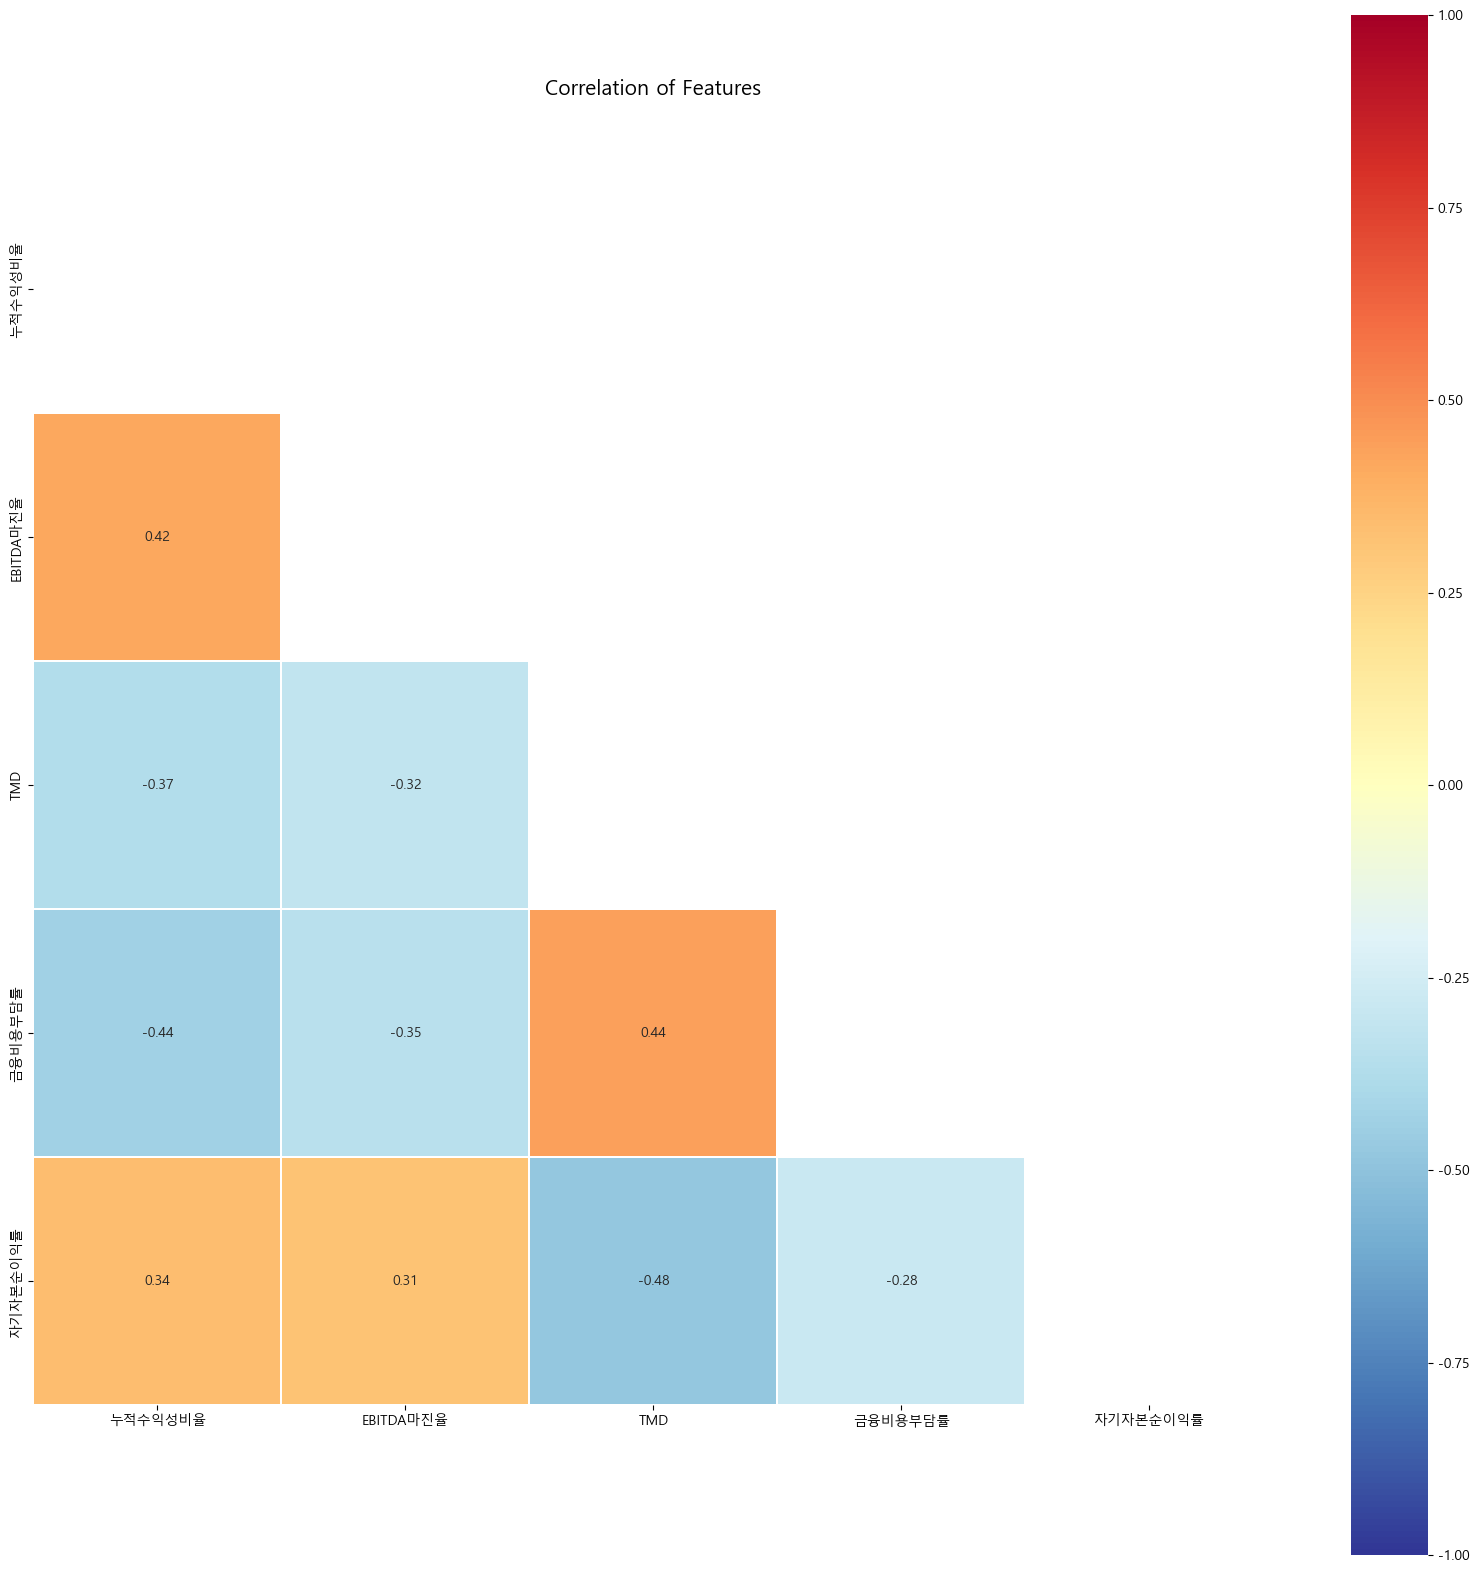

In [98]:
colormap = plt.cm.hot

corr = x_train_1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [99]:
model_basic(x_train_1,y_train,x_train_1,y_train)

[[3385    3]
 [  15   35]]
[[3384    4]
 [  16   34]]
[[3306   82]
 [   7   43]]
[[3388    0]
 [   0   50]]
[[3388    0]
 [   0   50]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9948,0.9211,0.70,0.7955,0.9920
1,LinearDiscriminantAnalysis(),0.9942,0.8947,0.68,0.7727,0.9864
2,GaussianNB(),0.9741,0.3440,0.86,0.4914,0.9881
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.00,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.00,1.0000,1.0000


In [100]:
model_basic(x_train_1,y_train,x_test_1,y_test)

[[1970   44]
 [   6    3]]
[[1972   42]
 [   6    3]]
[[1866  148]
 [   3    6]]
[[1958   56]
 [   5    4]]
[[1972   42]
 [   6    3]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9753,0.0638,0.3333,0.1071,0.9634
1,LinearDiscriminantAnalysis(),0.9763,0.0667,0.3333,0.1111,0.9510
2,GaussianNB(),0.9254,0.0390,0.6667,0.0736,0.9411
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9698,0.0667,0.4444,0.1159,0.9016
4,"XGBClassifier(base_score=None, booster=None, c...",0.9763,0.0667,0.3333,0.1111,0.9587


-----
# target2

In [101]:
x_train = train[col_int]
y_train = train[['target_2']]

x_test = test[col_int]
y_test = test[['target_2']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_2 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_2.index = x_train.columns

In [102]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_2["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_2["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_2["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_2['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_bwd'] = selector.get_support().tolist()

In [103]:
for col in df_select_2.columns.to_list():
    df_select_2[col] = df_select_2[col].apply(lambda x : 1 if x==True else 0)
df_select_2['total'] = df_select_2.sum(axis=1)
df_select_2[df_select_2['total']>=5].index

Index(['총자본정상영업이익률', '누적수익성비율', 'EBITDA마진율', 'TMD', '금융비용부담률', '자기자본순이익률',
       '총자본증가율'],
      dtype='object')

In [104]:
df_select_2[df_select_2['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본정상영업이익률,0,1,1,1,1,1,0,5
누적수익성비율,1,1,1,1,1,0,1,6
EBITDA마진율,1,1,1,0,1,1,1,6
TMD,1,1,1,0,1,0,1,5
금융비용부담률,1,1,1,1,0,1,0,5
자기자본순이익률,1,1,1,0,0,1,1,5
총자본증가율,0,1,1,0,1,1,1,5


In [105]:
최종_col =df_select_2[df_select_2['total']>=5].index.to_list()

x_train_2 = x_train[최종_col]
x_test_2 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

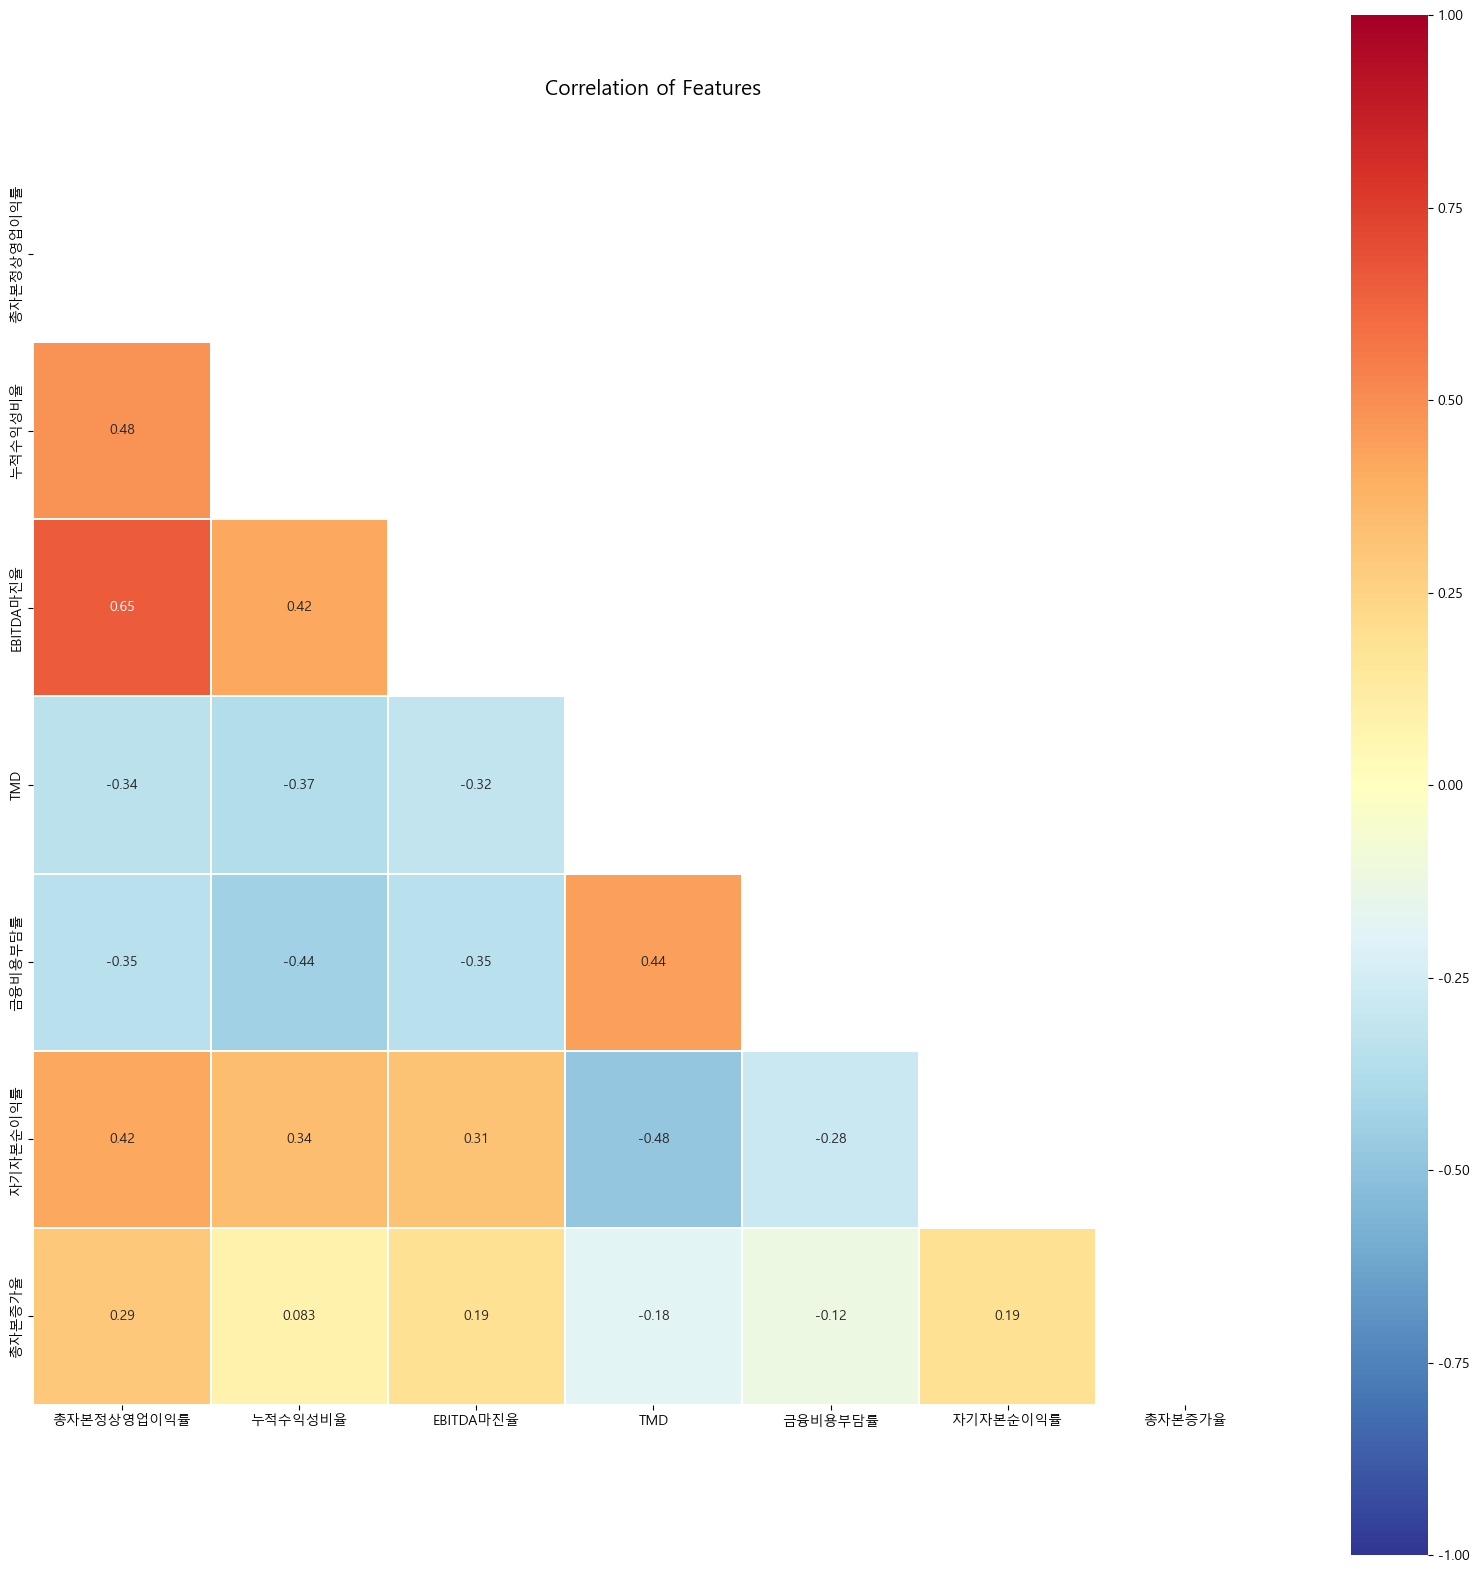

In [106]:
colormap = plt.cm.hot

corr = x_train_2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [107]:
model_basic(x_train_2,y_train,x_train_2,y_train)

[[3392    6]
 [  14   26]]
[[3390    8]
 [  13   27]]
[[3326   72]
 [   6   34]]
[[3398    0]
 [   0   40]]
[[3398    0]
 [   0   40]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9942,0.8125,0.650,0.7222,0.9926
1,LinearDiscriminantAnalysis(),0.9939,0.7714,0.675,0.7200,0.9854
2,GaussianNB(),0.9773,0.3208,0.850,0.4658,0.9886
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.000,1.0000,1.0000


In [108]:
model_basic(x_train_2,y_train,x_test_2,y_test)

[[1986   31]
 [   4    2]]
[[1980   37]
 [   4    2]]
[[1854  163]
 [   1    5]]
[[1980   37]
 [   4    2]]
[[1997   20]
 [   4    2]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9827,0.0606,0.3333,0.1026,0.9811
1,LinearDiscriminantAnalysis(),0.9797,0.0513,0.3333,0.0889,0.9579
2,GaussianNB(),0.9189,0.0298,0.8333,0.0575,0.9538
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9797,0.0513,0.3333,0.0889,0.9689
4,"XGBClassifier(base_score=None, booster=None, c...",0.9881,0.0909,0.3333,0.1429,0.9742


----
# target3

In [109]:
x_train = train[col_int]
y_train = train[['target_3']]

x_test = test[col_int]
y_test = test[['target_3']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_3 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_3.index = x_train.columns

In [110]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_3["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_3["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_3["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_3['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_bwd'] = selector.get_support().tolist()

In [111]:
for col in df_select_3.columns.to_list():
    df_select_3[col] = df_select_3[col].apply(lambda x : 1 if x==True else 0)
df_select_3['total'] = df_select_3.sum(axis=1)
df_select_3[df_select_3['total']>=5].index

Index(['총자본정상영업이익률', '누적수익성비율', 'EBITDA마진율', 'TMD', '금융비용부담률', '자기자본순이익률',
       '총자본증가율'],
      dtype='object')

In [112]:
df_select_3[df_select_3['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
총자본정상영업이익률,0,1,1,1,1,1,0,5
누적수익성비율,1,1,1,1,1,0,1,6
EBITDA마진율,1,1,1,0,1,1,1,6
TMD,1,1,1,0,1,0,1,5
금융비용부담률,1,1,1,1,0,1,0,5
자기자본순이익률,1,1,1,0,0,1,1,5
총자본증가율,0,1,1,0,1,1,1,5


In [113]:
최종_col =df_select_3[df_select_3['total']>=5].index.to_list()

x_train_3 = x_train[최종_col]
x_test_3 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

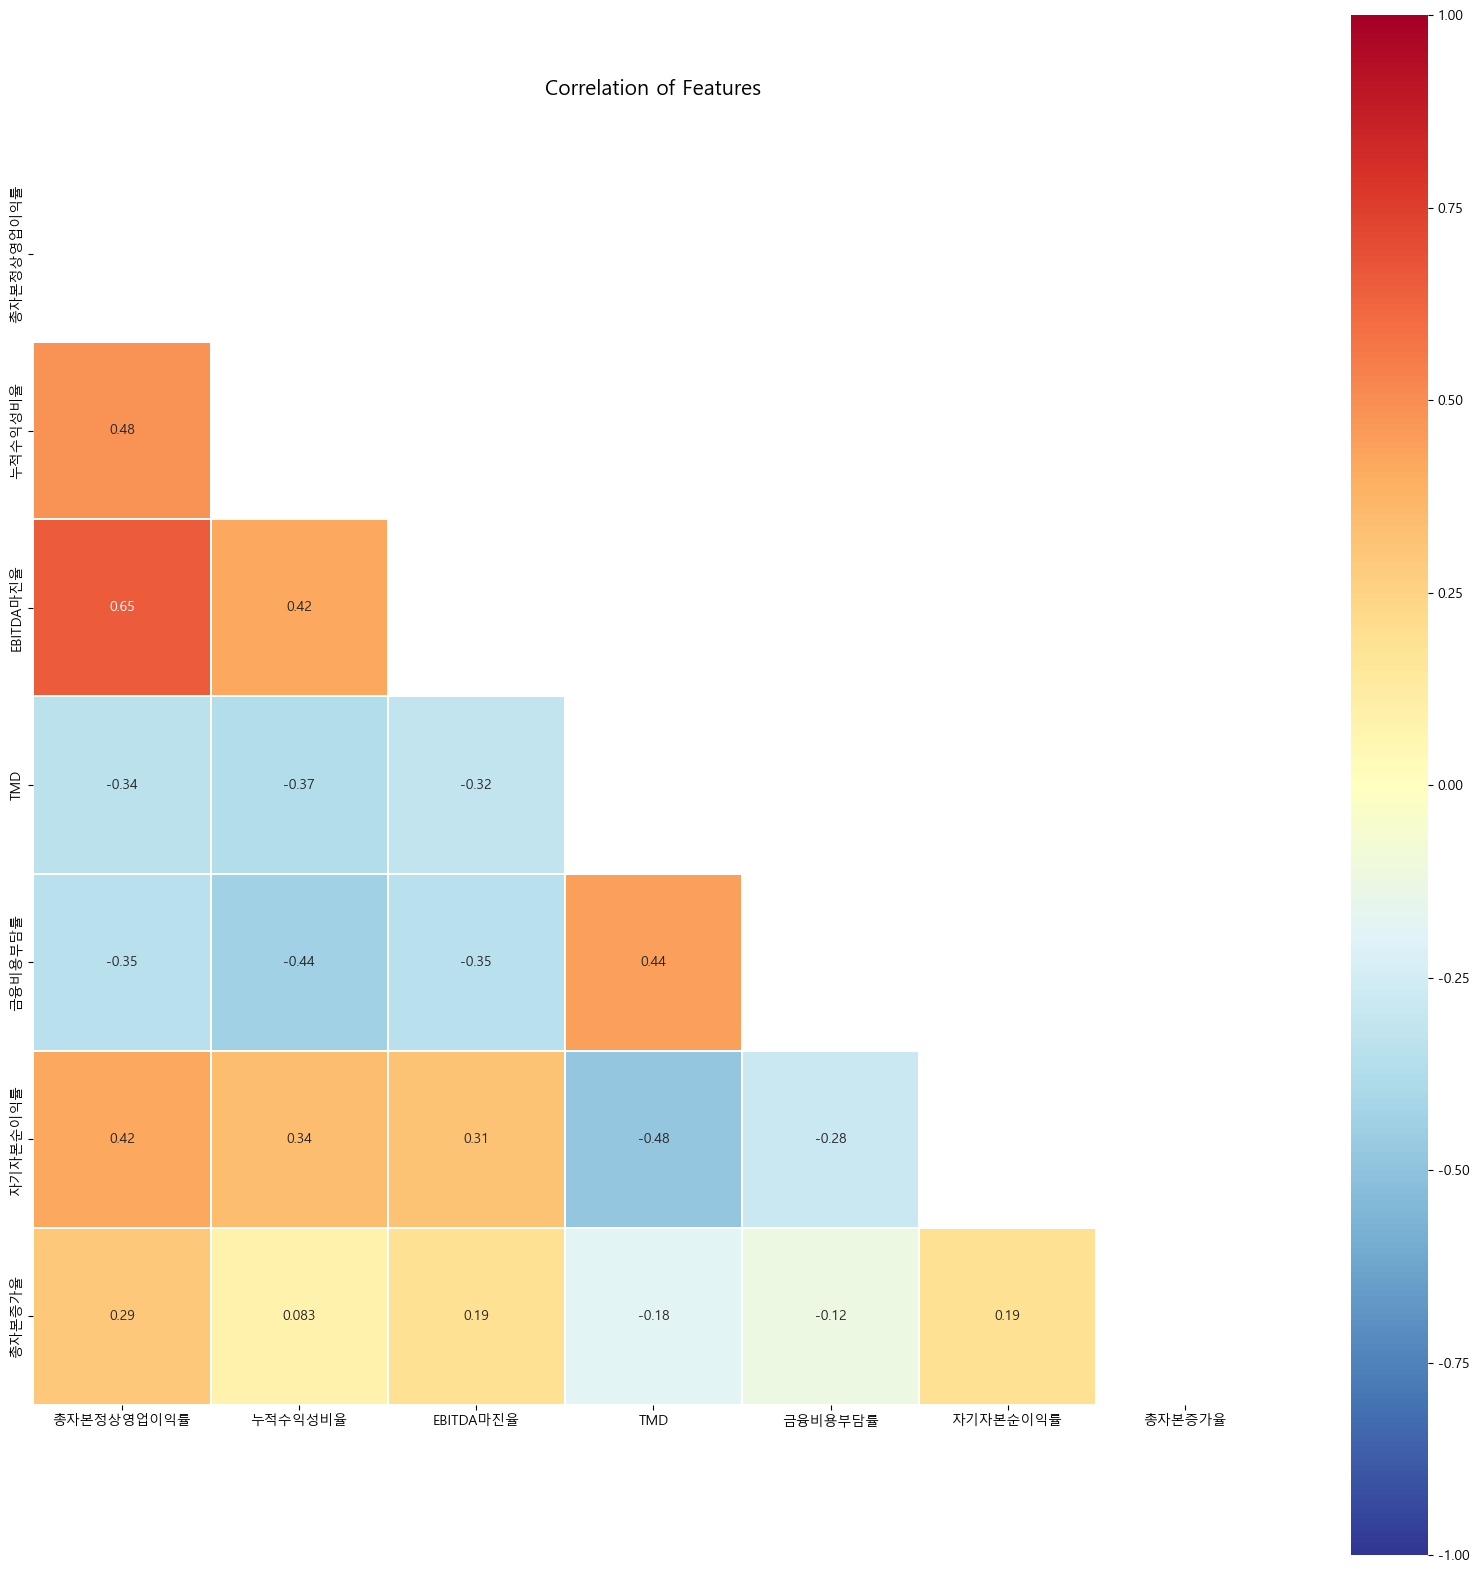

In [114]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [115]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[3392    6]
 [  14   26]]
[[3390    8]
 [  13   27]]
[[3326   72]
 [   6   34]]
[[3398    0]
 [   0   40]]
[[3398    0]
 [   0   40]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9942,0.8125,0.650,0.7222,0.9926
1,LinearDiscriminantAnalysis(),0.9939,0.7714,0.675,0.7200,0.9854
2,GaussianNB(),0.9773,0.3208,0.850,0.4658,0.9886
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.000,1.0000,1.0000


In [116]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[1986   31]
 [   4    2]]
[[1980   37]
 [   4    2]]
[[1854  163]
 [   1    5]]
[[1984   33]
 [   4    2]]
[[1997   20]
 [   4    2]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9827,0.0606,0.3333,0.1026,0.9811
1,LinearDiscriminantAnalysis(),0.9797,0.0513,0.3333,0.0889,0.9579
2,GaussianNB(),0.9189,0.0298,0.8333,0.0575,0.9538
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9817,0.0571,0.3333,0.0976,0.9667
4,"XGBClassifier(base_score=None, booster=None, c...",0.9881,0.0909,0.3333,0.1429,0.9742
